<a href="https://colab.research.google.com/github/Yaminibazzuri/Projects/blob/main/Digital_Phenotyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Phenotyping from NHANES Wearable Data (MIMS)

**Goal:** Build clinically interpretable *digital biomarkers* from free-living wearable data and show how simple summary metrics can miss meaningful *functional instability*.

**Dataset:** NHANES Physical Activity Monitor (PAXHD_H header + PAXDAY_H day-level).

**Outputs :**
1. Reproducible QC pipeline for valid wake-wear days  
2. Interpretable daily activity intensity metric (MIMS per wake-wear minute)  
3. Participant-level stability/instability biomarkers (mean, variability, weekend/weekday shift)  
4. Explainable phenotypes that separate “stable low” vs “unstable low” patterns  


In [1]:
# !pip -q install pyreadstat scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

PAXHD_PATH = "/content/PAXHD_H.xpt"
PAXDAY_PATH = "/content/PAXDAY_H.xpt"


## 1. Load NHANES PAM datasets
- **PAXHD_H**: device-level header information  
- **PAXDAY_H**: day-level summary (MIMS, wake wear, etc.)  

The work is primarily based off the **day-level** file and using the header file for metadata checks.


In [2]:
hd = pd.read_sas(PAXHD_PATH, format="xport")
day = pd.read_sas(PAXDAY_PATH, format="xport")

print("Header shape:", hd.shape)
print("Day-level shape:", day.shape)

hd.head()


Header shape: (8913, 9)
Day-level shape: (69018, 15)


,SEQN,PAXSTS,PAXSENID,PAXFDAY,PAXLDAY,PAXFTIME,PAXETLDY,PAXHAND,PAXORENT
0,73557.0,1.0,b'NEO1G22051089',b'3',b'9',b'16:30:00',b'16:38:59',b'1',b'1'
1,73558.0,1.0,b'NEO1G95371876',b'2',b'9',b'21:30:00',b'21:38:58',b'1',b'1'
2,73559.0,1.0,b'NEO1G50016094',b'7',b'9',b'12:30:00',b'12:38:58',b'1',b'1'
3,73560.0,1.0,b'NEO1G80563207',b'4',b'9',b'17:30:00',b'17:38:56',b'1',b'1'
4,73561.0,1.0,b'NEO1G21632829',b'2',b'9',b'12:30:00',b'12:38:53',b'1',b'1'


## 2. Cleaning utilities
NHANES XPT sometimes stores missing values as tiny floats and some columns as byte strings.
We'll standardize types and convert missing values to **NaN**.


In [3]:
SENTINEL_THRESH = 1e-50  # treat near-zero floats as missing (XPT artifacts)

def decode_bytes(x):
    if isinstance(x, (bytes, bytearray)):
        return x.decode("utf-8").strip()
    return x

def clean_xpt(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].map(decode_bytes)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].mask(df[num_cols].abs() < SENTINEL_THRESH, np.nan)
    return df

hdc = clean_xpt(hd)
dayc = clean_xpt(day)

# Convert coded columns to numeric where appropriate
for c in ["PAXFDAY","PAXLDAY","PAXHAND","PAXORENT"]:
    if c in hdc.columns:
        hdc[c] = pd.to_numeric(hdc[c], errors="coerce")

for c in ["PAXDAYD","PAXDAYWD"]:
    if c in dayc.columns:
        dayc[c] = pd.to_numeric(dayc[c], errors="coerce")

dayc.head()


,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,1,3,NaN,16:30:00,450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,NaN
1,73557.0,2,4,2160000.0,0:00:00,1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,NaN
2,73557.0,3,5,9072000.0,0:00:00,1440.0,3307840.0,1440.0,3158.922,147.0,NaN,1287.0,6.0,83407.33,NaN
3,73557.0,4,6,15984000.0,0:00:00,1440.0,6860400.0,1440.0,23.641,NaN,NaN,1439.0,1.0,NaN,NaN
4,73557.0,5,7,22896000.0,0:00:00,1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,NaN


## 3. Quality control: define "valid wake-wear" days

**Why this matters:** digital biomarkers are only meaningful if wear-time is adequate.

We use a conservative, explainable rule:
- `PAXWWMD` (valid wake wear minutes) **≥ 600 minutes/day**
- `PAXVMD` (valid minutes without QC flag) **≥ 600 minutes/day**

This mirrors common wake-wear thresholds used in free-living wearable studies.


In [4]:
df = dayc.copy()

# Interpretable intensity proxy: average MIMS per valid wake-wear minute
df["intensity_wake"] = df["PAXMTSD"] / df["PAXWWMD"]

# Define valid days
df["valid_day"] = (df["PAXWWMD"] >= 600) & (df["PAXVMD"] >= 600)

valid = df[df["valid_day"]].copy()

print("Participants with any day-level data:", df["SEQN"].nunique())
print("Participants with ≥1 valid day:", valid["SEQN"].nunique())
print("Valid days retained:", valid.shape[0])

valid[["SEQN","PAXDAYD","PAXDAYWD","PAXWWMD","PAXVMD","PAXMTSD","intensity_wake"]].head()


Participants with any day-level data: 7776
Participants with ≥1 valid day: 7401
Valid days retained: 47087


,SEQN,PAXDAYD,PAXDAYWD,PAXWWMD,PAXVMD,PAXMTSD,intensity_wake
1,73557.0,2,4,744.0,1440.0,12222.152,16.427624
6,73557.0,7,2,628.0,1440.0,11309.860,18.009331
10,73558.0,2,3,888.0,1440.0,13011.634,14.652741
11,73558.0,3,4,955.0,1440.0,9596.281,10.048462
12,73558.0,4,5,925.0,1440.0,10947.444,11.835075


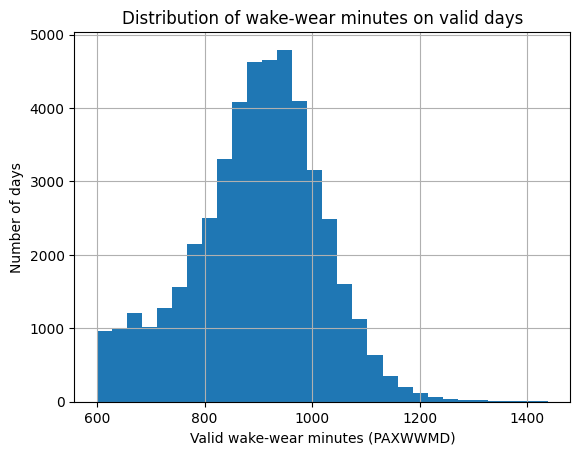

In [5]:
plt.figure()
valid["PAXWWMD"].hist(bins=30)
plt.xlabel("Valid wake-wear minutes (PAXWWMD)")
plt.ylabel("Number of days")
plt.title("Distribution of wake-wear minutes on valid days")
plt.show()


## 4. Participant-level biomarkers (digital phenotyping)

We summarize each participant into interpretable biomarkers:

- **Mean intensity** (MIMS / wake-minute): overall free-living functional activity  
- **Variability / instability (CV)**: day-to-day volatility (possible flares/avoidance)  
- **Weekend/weekday ratio**: behavior shift  
- **Mean wake wear**: adherence context  

We require **≥ 4 valid days** for stable estimates.


In [6]:
# Weekend definition (NHANES day-of-week typically 1=Sunday ... 7=Saturday)
valid["is_weekend"] = valid["PAXDAYWD"].isin([1, 7])

g = valid.groupby("SEQN")

feat = pd.DataFrame({
    "n_valid_days": g.size(),
    "mean_intensity": g["intensity_wake"].mean(),
    "sd_intensity": g["intensity_wake"].std(),
    "cv_intensity": g["intensity_wake"].std() / g["intensity_wake"].mean(),
    "mean_wakewear": g["PAXWWMD"].mean(),
    "mean_mims": g["PAXMTSD"].mean(),
})

# weekend/weekday ratio
weekend = g.apply(lambda x: x.loc[x["is_weekend"], "intensity_wake"].mean())
weekday = g.apply(lambda x: x.loc[~x["is_weekend"], "intensity_wake"].mean())
feat["weekend_weekday_ratio"] = weekend / weekday

feat = feat.replace([np.inf, -np.inf], np.nan)

# keep participants with enough valid days
feat = feat[feat["n_valid_days"] >= 4].dropna(
    subset=["mean_intensity","cv_intensity","mean_wakewear","weekend_weekday_ratio"]
)

print("Participants included after QC:", feat.shape[0])
feat.head()


/tmp/ipython-input-1435216346.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekend = g.apply(lambda x: x.loc[x["is_weekend"], "intensity_wake"].mean())


Participants included after QC: 6621


/tmp/ipython-input-1435216346.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekday = g.apply(lambda x: x.loc[~x["is_weekend"], "intensity_wake"].mean())


,n_valid_days,mean_intensity,sd_intensity,cv_intensity,mean_wakewear,mean_mims,weekend_weekday_ratio
SEQN,,,,,,,
73558.0,7,12.240396,1.499259,0.122485,856.714286,10480.064571,0.932130
73559.0,7,12.199622,1.372173,0.112477,787.857143,9605.735143,1.118035
73560.0,7,26.583800,3.305754,0.124352,880.142857,23256.377429,0.867111
73561.0,7,9.486536,0.967249,0.101960,802.714286,7637.048429,1.076036
73562.0,8,17.623891,4.315208,0.244850,915.000000,16147.576375,0.552430


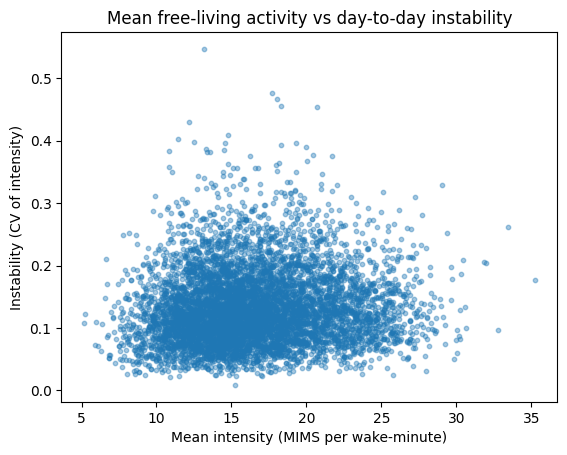

In [7]:
plt.figure()
plt.scatter(feat["mean_intensity"], feat["cv_intensity"], s=10, alpha=0.4)
plt.xlabel("Mean intensity (MIMS per wake-minute)")
plt.ylabel("Instability (CV of intensity)")
plt.title("Mean free-living activity vs day-to-day instability")
plt.show()


## 5. Explainable phenotypes (clustering)

We cluster participants using interpretable biomarkers:

- mean_intensity  
- cv_intensity  
- mean_wakewear  
- weekend_weekday_ratio  

We use **K-Means** (simple and explainable) with `k=4` phenotypes.


In [8]:
X = feat[["mean_intensity","cv_intensity","mean_wakewear","weekend_weekday_ratio"]].copy()
X = X.fillna(X.median())

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
feat["cluster"] = km.fit_predict(Xs)

feat["cluster"].value_counts().sort_index()


,count
cluster,
0,1165
1,2679
2,919
3,1858


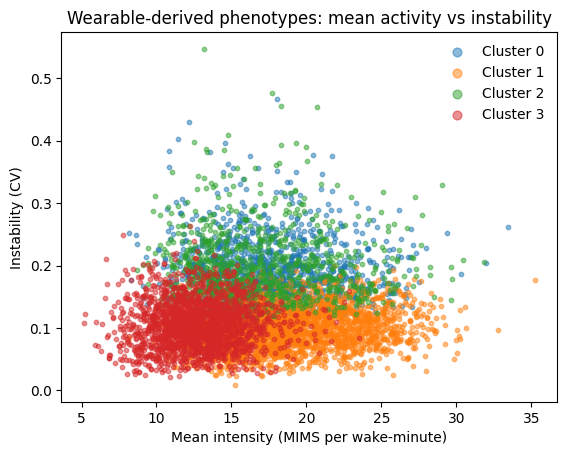

In [9]:
plt.figure()
for c in sorted(feat["cluster"].unique()):
    sub = feat[feat["cluster"] == c]
    plt.scatter(sub["mean_intensity"], sub["cv_intensity"], s=10, alpha=0.5, label=f"Cluster {c}")
plt.xlabel("Mean intensity (MIMS per wake-minute)")
plt.ylabel("Instability (CV)")
plt.title("Wearable-derived phenotypes: mean activity vs instability")
plt.legend(markerscale=2, frameon=False)
plt.show()


## 6. Make the result clinically interpretable

We summarize each phenotype with median values and then create simple labels.

**Takeaway:** This method separates **Stable Low** from **Unstable Low**—
two groups that may look similar under average activity alone.


In [10]:
summary = feat.groupby("cluster")[["n_valid_days","mean_intensity","cv_intensity","mean_wakewear","weekend_weekday_ratio"]].median().round(3)
summary


,n_valid_days,mean_intensity,cv_intensity,mean_wakewear,weekend_weekday_ratio
cluster,,,,,
0,7.0,17.304,0.184,907.667,0.801
1,7.0,18.107,0.101,939.857,0.994
2,7.0,16.205,0.187,898.286,1.240
3,7.0,12.621,0.105,839.000,0.996


In [11]:
mi_med = feat["mean_intensity"].median()
cv_med = feat["cv_intensity"].median()

def label_row(r):
    if r["mean_intensity"] < mi_med and r["cv_intensity"] >= cv_med:
        return "Unstable Low Activity (possible flare/avoidance)"
    if r["mean_intensity"] < mi_med and r["cv_intensity"] < cv_med:
        return "Stable Low Activity (consistently low)"
    if r["mean_intensity"] >= mi_med and r["cv_intensity"] >= cv_med:
        return "Unstable Higher Activity (variable/inconsistent)"
    return "Stable Higher Activity (consistently active)"

feat["phenotype_label"] = feat.apply(label_row, axis=1)
feat["phenotype_label"].value_counts()


,count
phenotype_label,
Unstable Higher Activity (variable/inconsistent),1770
Stable Low Activity (consistently low),1769
Stable Higher Activity (consistently active),1541
Unstable Low Activity (possible flare/avoidance),1541


## 7. A single-number “Instability Index”

For a one-number summary, define an **Instability Index** that increases when variability is high and mean intensity is low.

This is not a validated clinical metric — it’s a communication tool and a starting point for modeling.


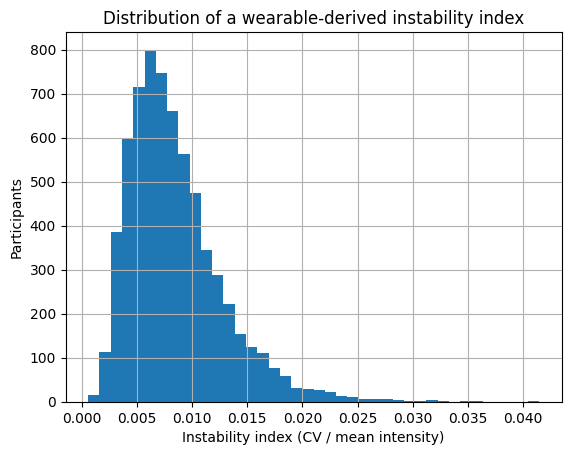

,mean_intensity,cv_intensity,instability_index
count,6621.000,6621.000,6621.000
mean,16.525,0.132,0.008
std,4.356,0.059,0.004
min,5.153,0.009,0.001
25%,13.357,0.091,0.005
50%,15.958,0.123,0.008
75%,19.313,0.163,0.011
max,35.235,0.547,0.041


In [12]:
feat["instability_index"] = feat["cv_intensity"] * (1 / feat["mean_intensity"])

plt.figure()
feat["instability_index"].hist(bins=40)
plt.xlabel("Instability index (CV / mean intensity)")
plt.ylabel("Participants")
plt.title("Distribution of a wearable-derived instability index")
plt.show()

feat[["mean_intensity","cv_intensity","instability_index"]].describe().round(3)
